In [1]:
import cv2 as cv
import numpy as np
import random
from PIL import Image
from image_utils import *
from canvas import *
from scipy import ndimage
from sampling import Sampler
from config import parse_cfg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def display(img):
    return Image.fromarray(img)

In [3]:
def place_above(canvas, num, dot_coords):

    top_left_row = dot_coords['min_row'] - num.shape[0] - random.randint(0, 10)
    top_left_col = dot_coords['min_col'] + random.randint(-20, 20)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

def place_below(canvas, num, dot_coords):
        
    top_left_row = dot_coords['max_row'] + random.randint(0, 10)
    top_left_col = dot_coords['min_col'] + random.randint(-20, 20)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

def place_right(canvas, num, dot_coords):
    
    top_left_row = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_col = dot_coords['max_col'] + random.randint(0, 10)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

def place_left(canvas, num, dot_coords):
    
    top_left_row = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_col = dot_coords['min_col'] - num.shape[1] - random.randint(0, 10)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

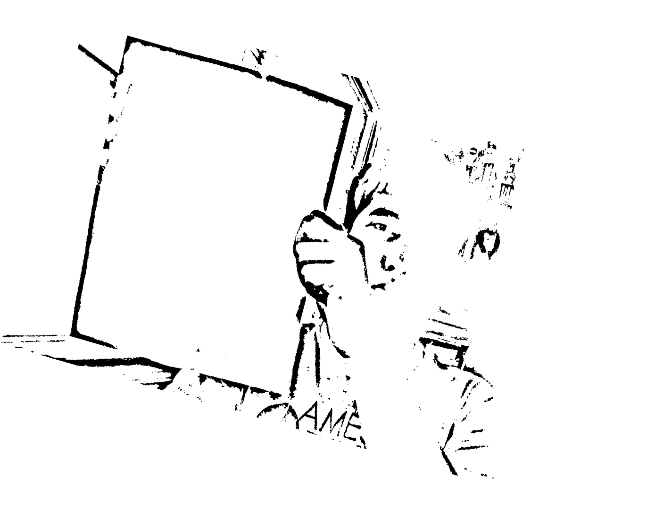

In [4]:
display(cv.resize(ndimage.rotate(get_canvases('canvases')[0].img, angle=-15.43, cval=255), (672, 512)))

In [84]:
a.img.shape

(720, 1280)

{'1': [((491, 363), (538, 363), (538, 414), (491, 414)), ((462, 180), (509, 180), (509, 231), (462, 231))]}
[[491 538 538 491]
 [363 363 414 414]]
[[568 613 626 581]
 [554 542 592 604]]

[[462 509 509 462]
 [180 180 231 231]]
[[492 538 551 506]
 [385 373 422 434]]



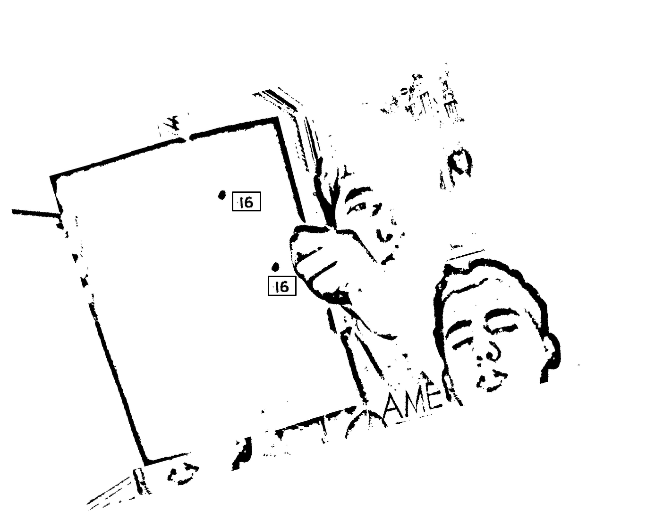

In [217]:
blanks = get_canvases('canvases')
blank_sampler = Sampler(blanks)

a = blank_sampler.get_sample()
a.img = adaptive_thresh(a.img)

names, imgs = get_img_data('nums/ones')
num_sampler = Sampler(imgs)

func = [place_above, place_below, place_left, place_right]

bbox = {}

dot = np.load('dots/1.npy')
dot = adaptive_thresh(dot)

for i in range(2):
    num = num_sampler.get_sample()
    num = ndimage.rotate(num, angle=-10, cval=255)

    row = random.randint(a.min_row, a.max_row)
    col = random.randint(a.min_col, a.max_col)
    
    while not a.draw_on_paper(num, (row, col)):
        row = random.randint(a.min_row, a.max_row)
        col = random.randint(a.min_col, a.max_col)
    
    # placed num
    
    if '1' not in bbox:
        bbox['1'] = []
        
        # tl tr br bl
    
    bbox['1'].append( ((col, row), (col+num.shape[1], row), (col+num.shape[1], row+num.shape[0]), (col, row+num.shape[0])) )

    top_left = row, col
    bot_right = row+dot.shape[0], col+dot.shape[1]
    
    dot_coords = {}
    dot_coords['min_row'] = top_left[0]
    dot_coords['max_row'] = bot_right[0]
    dot_coords['min_col'] = top_left[1]
    dot_coords['max_col'] = bot_right[1]

    np.random.shuffle(func)
    
    for f in func:
        if f(a, dot, dot_coords):
            break
            
            
def totally_inside_paper(row, col, background, blank):
    
    return row >= blank.min_row and col >= blank.min_col and row + background.shape[0] < blank.max_row and col + background.shape[1] < blank.max_col

k = np.load('backgrounds/1.npy')

cnt = 2
for i in range(cnt):
    
    rr = random.randint(0, a.img.shape[0])
    rc = random.randint(0, a.img.shape[1])
    
    while(totally_inside_paper(rr,rc, k, a)):
        rr = random.randint(0, a.img.shape[0])
        rc = random.randint(0, a.img.shape[1])
    
    
    a.draw_on_background(k, (rr,rc))
    
deg = 15
img = ndimage.rotate(a.img, angle=deg, cval=255)
rad = np.deg2rad(deg)
rt = np.array([[np.cos(rad), np.sin(rad)], [-np.sin(rad), np.cos(rad)]])

print(bbox)
for k,v in bbox.items():
    for obj in v:
        print(np.array(obj).T)
        nw = np.dot(rt, np.array(obj).T - np.array([1280/2, 720/2]).reshape(2,-1)) + np.array([img.shape[1]/2, img.shape[0]/2]).reshape(2,-1)
        nw = nw.astype(np.int32)
        
        print(nw)
        img = cv.rectangle(img, tuple(nw[:, 0]), tuple(nw[:, 2]), (0), 2)
        print()
    
display(cv.resize(img, (672, 512)))